# Assignment 4

In this assignment, you'll combine the assignment 3 data set with nutrition data from the [USDA Food Composition Databases](https://ndb.nal.usda.gov/ndb/search/list). The CSV file `fresh.csv` contains the fresh fruits and vegetables data you extracted in assignment 3.

The USDA Food Composition Databases have a [documented](https://ndb.nal.usda.gov/ndb/doc/index) web API that returns data in JSON format . You need a key in order to use the API. Only 1000 requests are allowed per hour, so it would be a good idea to use [caching][requests_cache].

[Sign up for an API key here](https://api.data.gov/signup/). The key will work with any Data.gov API. You may need the key again later in the quarter, so make sure you save it.

These modules may be useful:

* [requests](http://docs.python-requests.org/en/master/user/quickstart/)
* [requests_cache][]
* [urlparse](https://docs.python.org/2/library/urlparse.html)
* [pandas](http://pandas.pydata.org/pandas-docs/stable/)

[requests_cache]: https://pypi.python.org/pypi/requests-cache

Import some packages

In [15]:
from urllib2 import Request, urlopen
from urlparse import urlparse, urlunparse
import requests, requests_cache
import pandas as pd
import json
import csv
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
requests_cache.install_cache('coll_cache')

__Exercise 1.1.__ Read the [search request documentation](https://ndb.nal.usda.gov/ndb/doc/apilist/API-SEARCH.md), then write a function called `ndb_search()` that makes a search request. The function should accept the search term as an argument. The function should return the search result items as a list (for 0 items, return an empty list).

Note that the search url is: `https://api.nal.usda.gov/ndb/search`

As an example, a search for `"quail eggs"` should return this list:

```python
[{u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'CHAOKOH, QUAIL EGG IN BRINE, UPC: 044738074186',
  u'ndbno': u'45094707',
  u'offset': 0},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'L&W, QUAIL EGGS, UPC: 024072000256',
  u'ndbno': u'45094890',
  u'offset': 1},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'BUDDHA, QUAIL EGGS IN BRINE, UPC: 761934535098',
  u'ndbno': u'45099560',
  u'offset': 2},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'GRAN SABANA, QUAIL EGGS, UPC: 819140010103',
  u'ndbno': u'45169279',
  u'offset': 3},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u"D'ARTAGNAN, QUAIL EGGS, UPC: 736622102630",
  u'ndbno': u'45178254',
  u'offset': 4},
 {u'ds': u'SR',
  u'group': u'Dairy and Egg Products',
  u'name': u'Egg, quail, whole, fresh, raw',
  u'ndbno': u'01140',
  u'offset': 5}]
```

As usual, make sure you document and test your function.

In [4]:
def ndb_search(keyword,key):
    """
    https://api.nal.usda.gov/ndb/search/?format=xml&q=butter&max=25&offset=0&api_key=DEMO_KEY
    This function makes a search request
    Input: The search term and API key
    Output: search result (list)
    """
    urlbase = "https://api.nal.usda.gov/ndb/search"
    payload = {'format':'json',"api_key":key, "max":50, "offset":0, 'q':keyword}
    response = requests.get(urlbase,params=payload)
    req = Request(response.url)
    lf = urlopen(req)
    js = json.loads(lf.read())
    if u'list' in js:
        return js[u'list'][u'item']
    else:
        return []

In [5]:
ndb_search("quail egg", key = "D1fCJ0XVRmPhVzJ1pvxThKOO5t1Z44VeQadaN3os")

[{u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'CHAOKOH, QUAIL EGG IN BRINE, UPC: 044738074186',
  u'ndbno': u'45094707',
  u'offset': 0},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'L&W, QUAIL EGGS, UPC: 024072000256',
  u'ndbno': u'45094890',
  u'offset': 1},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'BUDDHA, QUAIL EGGS IN BRINE, UPC: 761934535098',
  u'ndbno': u'45099560',
  u'offset': 2},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'GRAN SABANA, QUAIL EGGS, UPC: 819140010103',
  u'ndbno': u'45169279',
  u'offset': 3},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u"D'ARTAGNAN, QUAIL EGGS, UPC: 736622102630",
  u'ndbno': u'45178254',
  u'offset': 4},
 {u'ds': u'SR',
  u'group': u'Dairy and Egg Products',
  u'name': u'Egg, quail, whole, fresh, raw',
  u'ndbno': u'01140',
  u'offset': 5}]

__Exercise 1.2.__ Use your search function to get NDB numbers for the foods in the `fresh.csv` file. It's okay if you don't get an NDB number for every food, but try to come up with a strategy that gets most of them. Discuss your strategy in a short paragraph.

Hints:

* The foods are all raw and unbranded.
* You can test search terms with the [online search page](https://ndb.nal.usda.gov/ndb/search/list).
* You can convert the output of `ndb_search()` to a data frame with `pd.DataFrame()`.
* The string methods for [Python](https://docs.python.org/2/library/stdtypes.html#string-methods) and [Pandas](http://pandas.pydata.org/pandas-docs/stable/text.html#method-summary) are useful here. It's okay if you use _simple_ regular expressions in the Pandas methods, although this exercise can be solved without them.
* You can merge data frames that have a column in common with `pd.merge()`.

In [6]:
fresh = pd.read_csv('fresh.csv',header=0)
food = fresh['food']
fresh.head()

,form,price_per_lb,yield,lb_per_cup,price_per_cup,food,type
0,Fresh1,0.333412,0.52,0.330693,0.212033,watermelon,fruit
1,Fresh1,0.535874,0.51,0.374786,0.393800,cantaloupe,fruit
2,Fresh1,1.377962,0.74,0.407855,0.759471,tangerines,fruit
3,Fresh1,2.358808,0.94,0.319670,0.802171,strawberries,fruit
4,Fresh1,1.827416,0.94,0.363763,0.707176,plums,fruit


In [7]:
def getNDB(item):
    """
    To get the NDB numbers for the food
    Input: search items
    Output: NDB numbers
    """
    key = "D1fCJ0XVRmPhVzJ1pvxThKOO5t1Z44VeQadaN3os"
    result = ndb_search(item,key)
    ndb=[]
    for itm in result:
        if 'juice' not in itm[u'name'].lower():
            ndb.append(itm[u'ndbno'])
    return ndb

In [8]:
ndb_result = dict((f, getNDB(' '.join([' '.join(f.split('_')),'raw']))) for f in food)

In [9]:
kiwi = getNDB(' '.join(['kiwifruit','raw']))
red_cabbage = getNDB(' '.join(['cabbage','red','raw']))
cucumber_with_peel = getNDB(' '.join(['cucumber','peel','with','raw']))

In [10]:
fndb = pd.DataFrame.from_dict(ndb_result, orient='index')
fndb.reset_index(level=0, inplace=True)
df= fndb.ix[:,0:2]
df.columns = ['food','ndbno']
df.ndbno[df.food=='kiwi'] = kiwi[0] # adding a row
df2 = pd.DataFrame([['red cabbage', red_cabbage[0]], ['cucumbers with peel', cucumber_with_peel[0]]], columns=['food','ndbno'])
df = df.append(df2)
df = df.reset_index(drop=True)
df_total=pd.merge(fresh, df, on='food')
df_total.set_value(25, 'ndbno', cucumber_with_peel[0])
df_total.set_value(37, 'ndbno', red_cabbage[0])

,form,price_per_lb,yield,lb_per_cup,price_per_cup,food,type,ndbno
0,Fresh1,0.333412,0.520000,0.330693,0.212033,watermelon,fruit,09326
1,Fresh1,0.535874,0.510000,0.374786,0.393800,cantaloupe,fruit,09181
2,Fresh1,1.377962,0.740000,0.407855,0.759471,tangerines,fruit,09218
3,Fresh1,2.358808,0.940000,0.319670,0.802171,strawberries,fruit,09316
4,Fresh1,1.827416,0.940000,0.363763,0.707176,plums,fruit,09279
5,Fresh1,1.035173,0.730000,0.407855,0.578357,oranges,fruit,09201
6,Fresh1,6.975811,0.960000,0.319670,2.322874,raspberries,fruit,09302
7,Fresh1,2.173590,0.560000,0.341717,1.326342,pomegranate,fruit,09286
8,Fresh1,0.627662,0.510000,0.363763,0.447686,pineapple,fruit,09266
9,Fresh1,3.040072,0.930000,0.363763,1.189102,apricots,fruit,09021


To get the NDB numbers for the foods in the fresh.csv file, I first searched them manually with the online NDB search page to make sure the general format of search item. After checking, I found I can get most result with the format like "apple raw" with space and no commas. So I splited the name of food and join with "raw" to get the search terms. Here I also make sure 'juice' doesn't appear in the name for any of the foods. Using the function I wrote in 1.1 to get NDB numbers for 46 kinds of food. Here I only extracted the first value of NDB numbers because they matched best. After checking, I found there are three food that have no results, like kiwi, cabbage and cucumber. For kiwi, I changed the name into the kiwifruit to get the NDB number. For cabbage and cucumber, since there are red and green cabbage, peeled cucumber and cucumber with peels. I made specific search names for both of them to get their NDB number. Now, I extract all the NDB numbers for every food.

__Exercise 1.3.__ Read the [food reports V2 documentation](https://ndb.nal.usda.gov/ndb/doc/apilist/API-FOOD-REPORTV2.md), then write a function called `ndb_report()` that requests a _basic_ food report. The function should accept the NDB number as an argument and return the list of nutrients for the food.

Note that the report url is: `https://api.nal.usda.gov/ndb/V2/reports`

For example, for `"09279"` (raw plums) the first element of the returned list should be:

```python
{u'group': u'Proximates',
 u'measures': [{u'eqv': 165.0,
   u'eunit': u'g',
   u'label': u'cup, sliced',
   u'qty': 1.0,
   u'value': u'143.93'},
  {u'eqv': 66.0,
   u'eunit': u'g',
   u'label': u'fruit (2-1/8" dia)',
   u'qty': 1.0,
   u'value': u'57.57'},
  {u'eqv': 151.0,
   u'eunit': u'g',
   u'label': u'NLEA serving',
   u'qty': 1.0,
   u'value': u'131.72'}],
 u'name': u'Water',
 u'nutrient_id': u'255',
 u'unit': u'g',
 u'value': u'87.23'}
```

Be sure to document and test your function.

In [11]:
def ndb_report(ndb,key):
    """
    This function requests a basic food report
    Input: NDB number
    Output: The list of nutrients for the food
    """
    baseurl = "https://api.nal.usda.gov/ndb/V2/reports"
    payload1 = {'ndbno':ndb, 'type':'b','format':'json','api_key':key}
    response1 = requests.get(baseurl,params=payload1)
    req1 = Request(response1.url)
    lf1 = urlopen(req1)
    js = json.loads(lf1.read())
    if u'foods' in js:
        return js[u'foods'][0][u'food'][u'nutrients']
    else:
        return []

In [12]:
ndb_report("09279", key = "D1fCJ0XVRmPhVzJ1pvxThKOO5t1Z44VeQadaN3os")[0]

{u'group': u'Proximates',
 u'measures': [{u'eqv': 165.0,
   u'eunit': u'g',
   u'label': u'cup, sliced',
   u'qty': 1.0,
   u'value': u'143.93'},
  {u'eqv': 66.0,
   u'eunit': u'g',
   u'label': u'fruit (2-1/8" dia)',
   u'qty': 1.0,
   u'value': u'57.57'},
  {u'eqv': 151.0,
   u'eunit': u'g',
   u'label': u'NLEA serving',
   u'qty': 1.0,
   u'value': u'131.72'}],
 u'name': u'Water',
 u'nutrient_id': u'255',
 u'unit': u'g',
 u'value': u'87.23'}

__Exercise 1.4.__ Which foods provide the best combination of price, yield, and nutrition? You can use kilocalories as a measure of "nutrition" here, but more a detailed analysis is better. Use plots to support your analysis.

Here I use $kilocalories(per lb)*yield(per lb)/price(per lb)$ as the criteria to analyze the best combination of price yield and nutrition. The calculated value is larger, the food can provide the best combination.

So we need to extract the kilocalories, yield and price for every food.

In [27]:
nut=[]
for itm in df_total['ndbno']:
    val = pd.DataFrame(ndb_report(itm, key = "D1fCJ0XVRmPhVzJ1pvxThKOO5t1Z44VeQadaN3os"))['value'][1]
    nut.append(val)

In [62]:
table = pd.concat([df_total,pd.Series(nut).rename('kcal')],axis = 1)
table = table[['food', 'ndbno','price_per_lb', 'yield', 'kcal']]
tbale = table.apply(lambda x: pd.to_numeric(x, errors='ignore'))
table.head()

,food,ndbno,price_per_lb,yield,kcal
0,watermelon,09326,0.333412,0.52,30
1,cantaloupe,09181,0.535874,0.51,34
2,tangerines,09218,1.377962,0.74,53
3,strawberries,09316,2.358808,0.94,32
4,plums,09279,1.827416,0.94,46


In [64]:
table['kcal'] = table['kcal'].astype('float64') 
cal_val = [table.loc[i]['kcal']*table.loc[i]['yield']/table.loc[i]['price_per_lb'] for i in range(48)]
t = pd.concat([table,pd.Series(cal_val).rename('cal_value')],axis = 1)
t.head()

,food,ndbno,price_per_lb,yield,kcal,cal_value
0,watermelon,09326,0.333412,0.52,30.0,46.788953
1,cantaloupe,09181,0.535874,0.51,34.0,32.358366
2,tangerines,09218,1.377962,0.74,53.0,28.462326
3,strawberries,09316,2.358808,0.94,32.0,12.752201
4,plums,09279,1.827416,0.94,46.0,23.661826


In [67]:
t['food'][list(t['cal_value']).index(max(list(t['cal_value'])))]

'bananas'

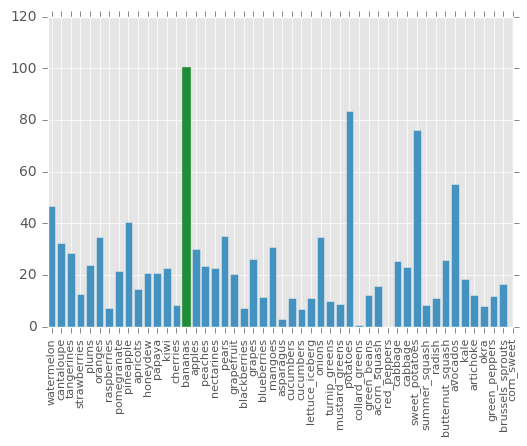

In [69]:
barlist = plt.bar(range(len(t['food'])),t['cal_value'], align = 'center', alpha = 0.7)
plt.xticks(range(len(t['food'])),t['food'],rotation = '90',size = 8)
barlist[list(t['cal_value']).index(max(list(t['cal_value'])))].set_color('g')
plt.show()

From the plot we can easily see bananas provide the best combination of price, yield, and nutrition. 